<p style="background-color:purple;font-size:20px;color:white" size="35"><b> 
Table of Content  </b> </p>

1. **[Data Introduction(Meta data)](#meta)**
2. **[Data Preparation](#prep)**
3. **[Splitting of data after it has been prepared](#intro)**
    - 3.1 - **[Train-Test Split of the data](#split)**
    - 3.2 - **[Why do we need to split the data?](#fit)**
4. **[What is the need of the Validation Set?](#vs)**
5. **[Cross Validation](#cv)**
    - 5.1 - **[Benefits of Cross Validation](#benefits)**
    - 5.2 - **[Sampling Techniques of Cross Validation](#sampling)**
        - 5.2.1 - **[Hold-out](#ho)**
        - 5.2.2 - **[K-fold Cross Validation](#kfold)**
        - 5.2.3 - **[Stratified K-fold Cross Validation](#skfold)**
        - 5.2.4 - **[Leave-P-out Cross Validation](#leave)**
4. **[Some more sampling techniques of doing cross validations](#extra)**

<a id="meta"></a>
## 1. Data Introduction

<body>
<h2 style="background-color:#0067a7; color:#FFFFFF"align="center">Admissions Prediction Dataset</h2>
</body>

This dataset is created for prediction of Graduate Admissions in a masters program from an Indian perspective.

It contains several parameters which are considered important during the application for Masters Programs.
The parameters included are :

    GRE Scores ( out of 340 )
    TOEFL Scores ( out of 120 )
    University Rating ( out of 5 )
    Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
    Undergraduate GPA ( out of 10 )
    Research Experience ( either 0 or 1 )
    Chance of Admit ( ranging from 0 to 1 )
    Acknowledgements
This dataset is inspired by the UCLA Graduate Dataset. The test scores and GPA are in the older format.
The dataset is owned by Mohan S Acharya.


This dataset was built with the purpose of helping students in shortlisting universities with their profiles. The predicted output gives them a fair idea about their chances for a particular university.

In [75]:
# Import Libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import functions to perform cross validation
from sklearn.model_selection import LeaveOneOut, LeavePOut
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, GroupKFold, LeaveOneGroupOut, GroupShuffleSplit, TimeSeriesSplit

from sklearn.ensemble import RandomForestClassifier

<a id="prep"></a>
## 2. Data Preparation

In [4]:
df_admissions = pd.read_csv('Admission_predict.csv')
df_admissions.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,1
1,2,324,107,4,4.0,4.5,8.87,1,1
2,3,316,104,3,3.0,3.5,8.00,1,0
3,4,322,110,3,3.5,2.5,8.67,1,1
4,5,314,103,2,2.0,3.0,8.21,0,0


In [5]:
df_admissions.shape

(400, 9)

In [6]:
df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
Serial No.           400 non-null int64
GRE Score            400 non-null int64
TOEFL Score          400 non-null int64
University Rating    400 non-null int64
SOP                  400 non-null float64
LOR                  400 non-null float64
CGPA                 400 non-null float64
Research             400 non-null int64
Chance of Admit      400 non-null int64
dtypes: float64(3), int64(6)
memory usage: 28.2 KB


According to the data definition, `Research` is a categorical variable, which is wrongly interpreted as 'int64', so we will convert these variables data type to 'object'.

In [7]:
df_admissions['Research'] = df_admissions['Research'].astype(object)

In [8]:
df_admissions = df_admissions.drop('Serial No.', axis = 1)
#We remove the column that has unique values

In [9]:
df_admissions.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

No null values are present

In [10]:
df_admissions.skew()

GRE Score           -0.062893
TOEFL Score          0.057216
University Rating    0.171260
SOP                 -0.275761
LOR                 -0.106991
CGPA                -0.065991
Research            -0.191582
Chance of Admit      0.201765
dtype: float64

Mostly all the columns are nearly normal

In [11]:
#taking out the target from the data
target = df_admissions['Chance of Admit']
df_feature = df_admissions.drop('Chance of Admit', axis = 1)

In [12]:
#select all the categorical variables
cat = df_feature.select_dtypes(include = [np.object])
cat.columns

Index(['Research'], dtype='object')

In [13]:
#convert categorical data to dummies
df_dummies = pd.get_dummies(data = cat, drop_first = True)

In [14]:
df_dummies.head()

,Research_1
0,1
1,1
2,1
3,1
4,0


In [15]:
# Scaling the numerical data
df_num = df_feature.select_dtypes(include = [np.number])
X_scaler = StandardScaler()
num_scaled = X_scaler.fit_transform(df_num)
df_num_scaled = pd.DataFrame(num_scaled, columns = df_num.columns)

In [16]:
#concatenating numerical and categorical data
X = pd.concat([df_num_scaled, df_dummies], axis = 1)
X.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research_1
0,1.762107,1.746971,0.798829,1.093864,1.167321,1.764818,1
1,0.627656,-0.067635,0.798829,0.596653,1.167321,0.455151,1
2,-0.070467,-0.562528,-0.076600,-0.397769,0.052933,-1.005631,1
3,0.453126,0.427257,-0.076600,0.099442,-1.061454,0.119339,1
4,-0.244998,-0.727492,-0.952029,-1.392191,-0.504260,-0.653029,0


<a id="intro"></a>
## 3. Splitting of data after it has been prepared

We generally divide our datasets into 3 parts before really applying any model to it.
The 3 parts of the datasets are called(#naming can vary):

        Training set
        Validation set
        Test set
        
**Training set**: That portion of the data that we provide to the model to do all the learning of various patterns and give us that hidden magical mapping function.

**Validation set**: Now this is like a hidden part which plays a very important role. It is that part of the training data that helps in evaluating the model while tuning its parameter making the model generalized.

**Test set**: This part of the data is never seen by the model, it is held out to check the final unbiased performance of the model.

In this article we will majorly focus on the Validation set of the data.


<a id="split"></a>
## 3.1 Train-Test Split

Before applying various Sampling techniques to the validation set , let us split the dataset in train and test set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state = 10, test_size = 0.2)
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (320, 7)
y_train (320,)
X_test (80, 7)
y_test (80,)


<a id="fit"></a>
## 3.2 Why do we need to split the data?

#### To prevent Overfitting and Underfitting

**Overfitting**: The process in which the model adapts very accurately to the given data,even in turn learning the patterns that are not meant to be learnt(i.e the patterns due to noise). This leads to inefficiany in predicting data that is even slightly different compared to the train data.

As such, the model performs very well for the training data, but stumbles comparatively with new data. The patterns developed from the training data do not generalise well to new unseen data.

To identify if there is overfitting in you data you need to see the difference in the train prediction error and the test prediction error. If the differnce is too high such that the train error is too low compared to test error , we call that model to be overfit on the train data(as seen below in the image)
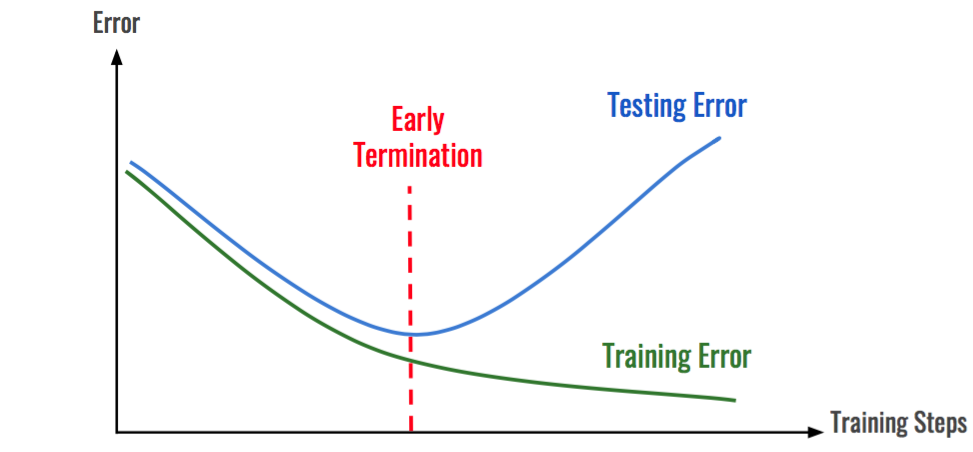
source: <https://hackernoon.com/hn-images/1*xWfbNW3arf39wxk4ZkI2Mw.png>

**Underfitting:** In this process the model adapts loosely to the given data which leads to in effeciency in even giving prediction on the same data itself.

Such a model would perform well neither on the training data nor any new data.For example imagine fitting a linear regression model to non-linear data.

To identify if there is underfitting in your data you will observe that both the train error and test error are quite high .We call that model to be underfit

So to get a model that is not underfit and not overfit we have to hit a sweet spot(as seen below in the image)
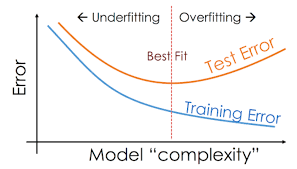

source<https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/Screenshot-2020-02-06-at-11.09.13.png>

**In the below image we can observe after fitting the best fit line on the data we can say whether the mdoel is overfit , underfit or just the correct fit**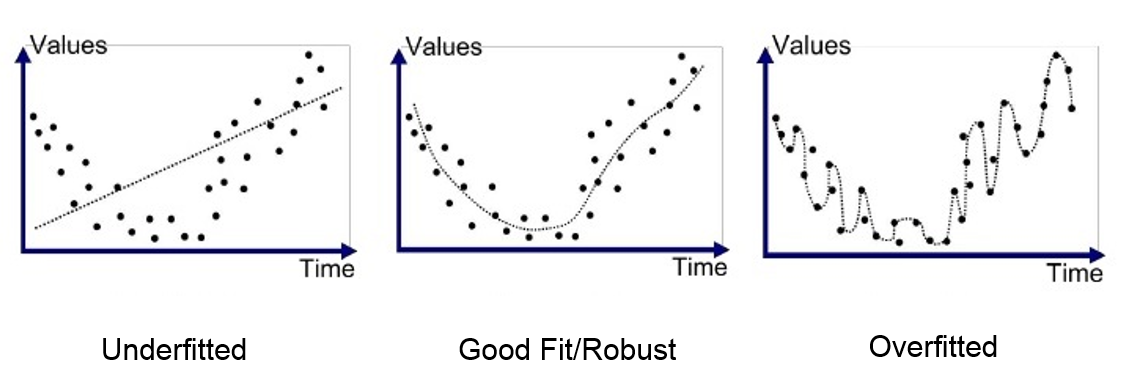


source: https://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76



<a id="vs"></a>
## 4. What is the need of the Validation Set?

**Validation:**

    There is always a need to test the performance of the model and make sure that the model is unbiased and has not memorized the noise as well of the data.
    We cannot just fit the model to the training data and expect it to work as perfectly on the data that it has never seen before. 
    The idea behind the validation is to get an assurance that the model is not very specific about even the noise of the data but has generically learnt the patterns inside it.
    
    Generally we calculate the training error after training the model. This training error can tell us how well the model has been trained but it does not tell us much about how robust the model is. 
    For a model to be generalized or robust there should be less bias and variance or in other words less underfitting and overfitting in the data. Getting this essence of the model is achieved by cross validation techniques.
    


#### Dividing Orignal data to train, test and validation
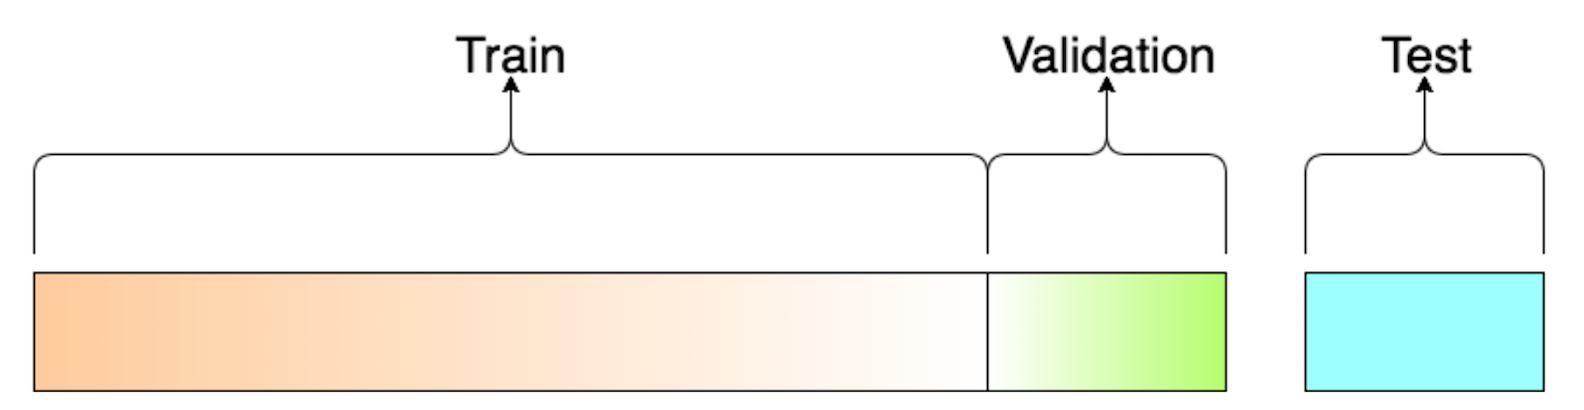
source:<http://www.dailysmarty.com/posts/setting-up-test-validation-and-training-sets-of-data>

<a id="cv"></a>
## 5. Cross Validation

Cross Validation is a very useful technique for assessing the effectiveness of your model, particularly in cases where you need to **mitigate overfitting**. 
    
It is also of use in determining the **hyper parameters** of your model, in the sense that which parameters will result in lowest test error. This is all the basic you need to get started with cross validation.

<a id="benefits"></a>
### 5.1. Benefits of Cross Validation

    It helps evaluate the quality of your model.
    It helps to reduce/avoid problems of overfitting and underfitting.
    It lets you select the model that will deliver the best performance on unseen data(hyper parameter tuning).

<a id="sampling"></a>
### 5.2 Sampling techniques of Cross Validation

#### Let us now have a look at a few methods of Sampling methods that we apply on the train data to get the validation set and further apply cross validation on the same.

<a id="ho"></a>
### 5.2.1 Holdout method

This is the most basic method where we take a small part of the train data out and do not show it while training. The train error here tells us how our model is performing on the unseen day. This is a very simple technique called the Hold out method.
Even though this technique doesnt need much of processing but the problem is that because we take out a random sample from the training data as the holdout then we cannot really rely upon the results. Results are high in variance.

In [19]:
#This is same as training data on train set and testing on the test set

In [20]:
# Fitting the Randon Forest with default hyperparameters
rf_start =RandomForestClassifier(random_state=42)
rf_start.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
# RESULTS FOR THE TRAIN SET
#Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

train_pred = rf_start.predict(X_train)

print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       178
           1       0.99      0.98      0.99       142

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320



In [42]:
# RESULTS FOR THE TEST SET
# Making predictions on the holdout
y_pred_default = rf_start.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86        42
           1       0.83      0.89      0.86        38

    accuracy                           0.86        80
   macro avg       0.86      0.86      0.86        80
weighted avg       0.87      0.86      0.86        80



#### Looking above train accuracy is: 99%
#### Test accuracy: 86%
The difference in the train accuracy and test accuracy = 13%

Which does show that the model can be overfit as it trains a lot better than test accuracy 

### Holdout after Hyper Parameter Tuning

#### Let us now tune the hyper parameters of Random forest and then perform the same holdout technique again.

    For this we set cv=2 in grid search cv to make it learn parameters on the train set itself

In [41]:
from sklearn.model_selection import GridSearchCV

# create a dictionary with hyperparameters and its values
tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [10, 30, 50, 70, 90],
                     'max_depth': [10, 15, 20],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2, 5, 8, 11],
                     'min_samples_leaf': [1, 5, 9],
                     'max_leaf_nodes': [2, 5, 8, 11]}]
 
# instantiate the 'RandomForestClassifier' 
# pass the 'random_state' to obtain the same samples for each time you run the code
random_forest_classification = RandomForestClassifier(random_state = 10)


rf_grid = GridSearchCV(estimator = random_forest_classification, 
                       param_grid = tuned_paramaters, 
                       cv = 2)

# use fit() to fit the model on the train set
rf_grid_model = rf_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for random forest classifier: ', rf_grid_model.best_params_, '\n')

Best parameters for random forest classifier:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50} 



In [42]:
# instantiate the 'RandomForestClassifier'
# 'best_params_' returns the dictionary containing best parameter values and parameter name  
# 'get()' returns the value of specified parameter
# pass the 'random_state' to obtain the same samples for each time you run the code
rf_model = RandomForestClassifier(criterion = rf_grid_model.best_params_.get('criterion'), 
                                  n_estimators = rf_grid_model.best_params_.get('n_estimators'),
                                  max_depth = rf_grid_model.best_params_.get('max_depth'),
                                  max_features = rf_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = rf_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = rf_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = rf_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

# use fit() to fit the model on the train set
rf_model = rf_model.fit(X_train, y_train)

# print the performance measures for test set for the model with best parameters
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)
print('Classification Report for train set:\n', classification_report(y_train, train_pred))
print('Classification Report for test set:\n', classification_report(y_test, test_pred))

Classification Report for train set:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       178
           1       0.92      0.84      0.88       142

    accuracy                           0.90       320
   macro avg       0.90      0.89      0.89       320
weighted avg       0.90      0.90      0.90       320

Classification Report for test set:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        42
           1       0.84      0.84      0.84        38

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80



In [64]:
#Train accuracy = 90
#Test accuracy = 85
#Difference is 5%

<a id="kfold"></a>
### 5.2.2 K-fold Cross validation

So as we saw above in the holdout , we are taking out a sample of the training data and keeping it away from training.

But we all know that there is no amount data that we can consider is enough for capturing the right patterns plus over that if we take out another set of holdout data from it, it can further decrease the possibility of training the model well.

Hence that it where out **K-fold cross validation** comes into picture where we have ample data to train and also validate our results.

In K-fold cross validation , **the data is divided into k subsets**. Now everytime, we take this kth subset as the holdout and train the model on the rest of the data.
After this we **average out the error estimation** that we have got on all the k subsets. Doing this we can be confident that every data point is coming in the validation part exactly once.

This method also **decreases bias** as we are training the model on all the k-1 respective subsets and similarly there will also be **less variance** as all the data points will for once be a part of the validation sets.

The value of K is not fixed and depends on the dataset. Generally the range of **K is between 5-10 depending on the size of the data** keeping in mind enough data will be available for training.

### CV=5

In [44]:
# n_splits: specify the number of k folds
kf = KFold(n_splits = 5)

In [45]:
# create an empty list to store the scores
scores = []
scores_train =[]

# kf.split() splits the indices of X_train into train_index and test_index
# further dividing the X_train and y_train sets into train and test sets for cross validation
# Remember: Cross validation works on training set not on test set
# use '\' for stacking the code 
for train_index, test_index in kf.split(X_train):
    X_train_k, X_test_k, y_train_k, y_test_k = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
   
    
    rf_start.fit(X_train_k, y_train_k)          # fit the model
    scores_train.append(rf_start.score(X_train_k, y_train_k))
    scores.append(rf_start.score(X_test_k, y_test_k))
    
# print all scores
print('All train scores: ', scores_train)
print('All test scores: ', scores)
print("\nMinimum train score obtained: ", round(min(scores_train), 4))
print("Minimum test score obtained: ", round(min(scores), 4))


print("\nMaximum train score obtained: ", round(max(scores_train), 4))
print("Maximum test score obtained: ", round(max(scores), 4))


print("\nAverage train score obtained: ", round(np.mean(scores_train), 4))
print("Average test score obtained: ", round(np.mean(scores), 4))

All train scores:  [0.9921875, 0.9921875, 0.984375, 0.98046875, 0.98828125]
All test scores:  [0.875, 0.78125, 0.84375, 0.90625, 0.8125]

Minimum train score obtained:  0.9805
Minimum test score obtained:  0.7812

Maximum train score obtained:  0.9922
Maximum test score obtained:  0.9062

Average train score obtained:  0.9875
Average test score obtained:  0.8438


#### Looking above train accuracy is: 98.7%
#### Test accuracy: 84.3%
Which does show that the model fit is overfit as it trains a lot better than test accuracy 

### Lets try and change value of K and see if that gives better result.

### CV=10

In [46]:
# n_splits: specify the number of k folds
kf = KFold(n_splits = 10)

In [47]:
# create an empty list to store the scores
scores = []
scores_train =[]

# kf.split() splits the indices of X_train into train_index and test_index
# further dividing the X_train and y_train sets into train and test sets for cross validation
# Remember: Cross validation works on training set not on test set
# use '\' for stacking the code 
for train_index, test_index in kf.split(X_train):
    X_train_k, X_test_k, y_train_k, y_test_k = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
   
    
    rf_start.fit(X_train_k, y_train_k)          # fit the model
    scores_train.append(rf_start.score(X_train_k, y_train_k))
    scores.append(rf_start.score(X_test_k, y_test_k))
    
# print all scores
print('All train scores: ', scores_train)
print('All test scores: ', scores)
print("\nMinimum train score obtained: ", round(min(scores_train), 4))
print("Minimum test score obtained: ", round(min(scores), 4))


print("\nMaximum train score obtained: ", round(max(scores_train), 4))
print("Maximum test score obtained: ", round(max(scores), 4))


print("\nAverage train score obtained: ", round(np.mean(scores_train), 4))
print("Average test score obtained: ", round(np.mean(scores), 4))

All train scores:  [0.9791666666666666, 0.9791666666666666, 0.9861111111111112, 0.9895833333333334, 0.9895833333333334, 0.9930555555555556, 0.9895833333333334, 0.9930555555555556, 0.9861111111111112, 0.9826388888888888]
All test scores:  [0.8125, 0.90625, 0.75, 0.8125, 0.875, 0.8125, 0.96875, 0.875, 0.84375, 0.90625]

Minimum train score obtained:  0.9792
Minimum test score obtained:  0.75

Maximum train score obtained:  0.9931
Maximum test score obtained:  0.9688

Average train score obtained:  0.9868
Average test score obtained:  0.8562


#### Looking above train accuracy is: 98.6%
#### Test accuracy: 85.6%
There is still quite a lot of difference in the train and test whcih is 13.0

### K-Fold Cross Validation using `cross_val_score()`

### CV=5

In [48]:
# using cross_val_score() for k-fold cross validation
# estimator:Here we are performing Random forest
# pass the X_train and y_train sets
# cv: stands for number of folds. Similar to k in KFold
# scoring: pass the scoring parameter e.g. 'r2' for r-squared, 'accuracy' for accuracy
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = rf_start, 
                         X = X_train, 
                         y = y_train, 
                         cv = 5, 
                         scoring = 'accuracy')

In [49]:
# print all scores
print('All scores: ', scores)

print("\nMinimum score obtained: ", round(min(scores), 4))


print("Maximum score obtained: ", round(max(scores), 4))


print("Average score obtained: ", round(np.mean(scores), 4))

All scores:  [0.86153846 0.78461538 0.8125     0.87301587 0.82539683]

Minimum score obtained:  0.7846
Maximum score obtained:  0.873
Average score obtained:  0.8314


#### Looking above train accuracy is: 98.6%
#### Test accuracy: 83.14%
There is still quite a lot of difference in the train and test whcih is 15.4

### CV=10

In [54]:
# using cross_val_score() for k-fold cross validation
# estimator:Here we are performing Random forest
# pass the X_train and y_train sets
# cv: stands for number of folds. Similar to k in KFold
# scoring: pass the scoring parameter e.g. 'r2' for r-squared, 'accuracy' for accuracy
scores = cross_val_score(estimator = rf_start, 
                         X = X_train, 
                         y = y_train, 
                         cv = 10, 
                         scoring = 'accuracy')

In [55]:
# print all scores
print('All scores: ', scores)

print("\nMinimum score obtained: ", round(min(scores), 4))


print("Maximum score obtained: ", round(max(scores), 4))


print("Average score obtained: ", round(np.mean(scores), 4))

All scores:  [0.84848485 0.90909091 0.84375    0.71875    0.90625    0.84375
 0.96875    0.84375    0.87096774 0.90322581]

Minimum score obtained:  0.7188
Maximum score obtained:  0.9688
Average score obtained:  0.8657


#### Looking above train accuracy is: 98.6%
#### Test accuracy: 86.57.6%
There is still quite a lot of difference in the train and test whcih is 12.03

We can observe that the test accuracies are similar to the above k fold techniques.

Also after applying k fold cross val the difference in train and test has decreased.

**The only problem with this direct function is that it doesnt gives us the train accuracy.**

<a id="skfold"></a>
### 5.2.3 Stratified K-fold cross validation

Now the problem with the simple K fold technique is that if the data that we have is highly imbalanced.
Then it can be possible that we have mostly all the negative cases in any one of the kth subset. And in most of the k subsets there will be maximum of samples in the training set to be positive which leads to high bias in the training.
For such problems, a slight change in the above technique is done , such that each fold cotains almost the same ratio of each class in the target. This is called Stratified K fold technique. 




In [58]:
target.value_counts(1)*100

0    55.0
1    45.0
Name: Chance of Admit, dtype: float64

### Since there is not much imbalance in the target column. Let us see if stratified k fold shows any difference

### CV=5

In [59]:
# n_splits: specify the number of k folds
skf = StratifiedKFold(n_splits = 5)

In [60]:
# create an empty list to store the scores
scores = []
scores_train =[]

# skf.split() splits the indices of X_train into train_index and test_index
# further dividing the X_train and y_train sets into train and test sets for cross validation
# Remember: Cross validation works on training set not on test set
# use '\' for stacking the code 
for train_index, test_index in skf.split(X_train,y_train):
    X_train_k, X_test_k, y_train_k, y_test_k = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
   
    
    rf_start.fit(X_train_k, y_train_k)          # fit the model
    scores_train.append(rf_start.score(X_train_k, y_train_k))
    scores.append(rf_start.score(X_test_k, y_test_k))
    
# print all scores
print('All train scores: ', scores_train)
print('All test scores: ', scores)
print("\nMinimum train score obtained: ", round(min(scores_train), 4))
print("Minimum test score obtained: ", round(min(scores), 4))


print("\nMaximum train score obtained: ", round(max(scores_train), 4))
print("Maximum test score obtained: ", round(max(scores), 4))


print("\nAverage train score obtained: ", round(np.mean(scores_train), 4))
print("Average test score obtained: ", round(np.mean(scores), 4))

All train scores:  [0.9882352941176471, 0.9921568627450981, 0.984375, 0.9844357976653697, 0.9883268482490273]
All test scores:  [0.8615384615384616, 0.7846153846153846, 0.8125, 0.873015873015873, 0.8253968253968254]

Minimum train score obtained:  0.9844
Minimum test score obtained:  0.7846

Maximum train score obtained:  0.9922
Maximum test score obtained:  0.873

Average train score obtained:  0.9875
Average test score obtained:  0.8314


### CV=10

In [61]:
# n_splits: specify the number of k folds
skf = StratifiedKFold(n_splits = 10)

In [62]:
# create an empty list to store the scores
scores = []
scores_train =[]

# skf.split() splits the indices of X_train into train_index and test_index
# further dividing the X_train and y_train sets into train and test sets for cross validation
# Remember: Cross validation works on training set not on test set
# use '\' for stacking the code 
for train_index, test_index in skf.split(X_train,y_train):
    X_train_k, X_test_k, y_train_k, y_test_k = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
   
    
    rf_start.fit(X_train_k, y_train_k)          # fit the model
    scores_train.append(rf_start.score(X_train_k, y_train_k))
    scores.append(rf_start.score(X_test_k, y_test_k))
    
# print all scores
print('All train scores: ', scores_train)
print('All test scores: ', scores)
print("\nMinimum train score obtained: ", round(min(scores_train), 4))
print("Minimum test score obtained: ", round(min(scores), 4))


print("\nMaximum train score obtained: ", round(max(scores_train), 4))
print("Maximum test score obtained: ", round(max(scores), 4))


print("\nAverage train score obtained: ", round(np.mean(scores_train), 4))
print("Average test score obtained: ", round(np.mean(scores), 4))

All train scores:  [0.9790940766550522, 0.9790940766550522, 0.9861111111111112, 0.9861111111111112, 0.9895833333333334, 0.9895833333333334, 0.9791666666666666, 0.9895833333333334, 0.9930795847750865, 0.9826989619377162]
All test scores:  [0.8484848484848485, 0.9090909090909091, 0.84375, 0.71875, 0.90625, 0.84375, 0.96875, 0.84375, 0.8709677419354839, 0.9032258064516129]

Minimum train score obtained:  0.9791
Minimum test score obtained:  0.7188

Maximum train score obtained:  0.9931
Maximum test score obtained:  0.9688

Average train score obtained:  0.9854
Average test score obtained:  0.8657


#### Looking above train accuracy is: 98.5%
#### Test accuracy: 86.57%
The difference in the train and test which is 12.0.
But here the accuracies are same as K fold

<a id="hyper"></a>
## 3.1 Tune the Hyperparameters using GridSearchCV (Random Forest)

### CV=10
**As we can see that cv=10 gives less overfitting i.e difference in train and test accuracy**

In [38]:
from sklearn.model_selection import GridSearchCV

# create a dictionary with hyperparameters and its values
tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [10, 30, 50, 70, 90],
                     'max_depth': [10, 15, 20],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2, 5, 8, 11],
                     'min_samples_leaf': [1, 5, 9],
                     'max_leaf_nodes': [2, 5, 8, 11]}]
 
# instantiate the 'RandomForestClassifier' 
# pass the 'random_state' to obtain the same samples for each time you run the code
random_forest_classification = RandomForestClassifier(random_state = 10)


rf_grid = GridSearchCV(estimator = random_forest_classification, 
                       param_grid = tuned_paramaters, 
                       cv = 10)

# use fit() to fit the model on the train set
rf_grid_model = rf_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for random forest classifier: ', rf_grid_model.best_params_, '\n')

Best parameters for random forest classifier:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50} 



#### Build the model using the tuned hyperparameters.

In [40]:
# instantiate the 'RandomForestClassifier'
# 'best_params_' returns the dictionary containing best parameter values and parameter name  
# 'get()' returns the value of specified parameter
# pass the 'random_state' to obtain the same samples for each time you run the code
rf_model = RandomForestClassifier(criterion = rf_grid_model.best_params_.get('criterion'), 
                                  n_estimators = rf_grid_model.best_params_.get('n_estimators'),
                                  max_depth = rf_grid_model.best_params_.get('max_depth'),
                                  max_features = rf_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = rf_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = rf_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = rf_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

# use fit() to fit the model on the train set
rf_model = rf_model.fit(X_train, y_train)

# print the performance measures for test set for the model with best parameters
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)
print('Classification Report for train set:\n', classification_report(y_train, train_pred))
print('Classification Report for test set:\n', classification_report(y_test, test_pred))

Classification Report for train set:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       178
           1       0.92      0.85      0.88       142

    accuracy                           0.90       320
   macro avg       0.90      0.89      0.90       320
weighted avg       0.90      0.90      0.90       320

Classification Report for test set:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87        42
           1       0.85      0.87      0.86        38

    accuracy                           0.86        80
   macro avg       0.86      0.86      0.86        80
weighted avg       0.86      0.86      0.86        80



#In grid search CV we are doing hyparameter tuning while performing k fold cross validation.
#We have used CV = 10 here as that was giving us less overfit in the previous step.

#We can observe that the average after picking the best params and refitting the model on the best params we are getting 

**TRAIN ACCURACY= 90%**
**TEST ACCURACY = 86%**

***Now here even the parameters that we have chosen are best and these parameters are chosen using cross validation which ultimately even decreases the difference between train and test accuracy***

<a id="leave"></a>
### 5.2.4 Leave-P-Out Cross Validation

In this approach as the name suggests we leave p samples out of the total training set as the validation set.
Therefor now we have p samples in the validation data and n-p samples in the training data. This is repeated in such a way that we take all posible p samples from the dataset and keep the rest as training set.
Similar to k fold technique we then average out the estimation error.

The specific case for this method is when we have p=1 called the leave one out cross validation technique.
This is better that taking p as some other value as we do not haveto take all posib;e combinations of p samples rather we just pick out the number of possible combinatiosn as the number of samples in the training data.

In [85]:
# create an empty to store the MSE for each model
loocv_score = []
loocv_train_score = []

# instantiate the LOOCV method 
loocv = LeaveOneOut()

# use the for loop to build the classification model for each cross validation 
# use split() to split the dataset into two subsets; one with (n-1) data points and another with 1 data point
# where, n = total number of observations

for train_index, test_index in loocv.split(X_train):
    # create the train dataset, use iloc[] to retrieve the corresponding observations in train data
    # create the test dataset, use iloc[] to retrieve the corresponding observations in test data
    # # use '\' for stacking the code 
    X_train_l, X_test_l, y_train_l, y_test_l = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
    
    
    
    # fit the model on training dataset
    rf_start.fit(X_train_l, y_train_l)
    
    
    loocv_train_score.append(rf_start.score(X_train_l, y_train_l))
    loocv_score.append(rf_start.score(X_test_l, y_test_l))
    
    
# print all scores
print("\nMinimum train score obtained: ", round(min(loocv_train_score), 4))
print("Minimum test score obtained: ", round(min(loocv_score), 4))


print("\nMaximum train score obtained: ", round(max(loocv_train_score), 4))
print("Maximum test score obtained: ", round(max(loocv_score), 4))


print("\nAverage train score obtained: ", round(np.mean(loocv_train_score), 4))
print("Average test score obtained: ", round(np.mean(loocv_score), 4))    


Minimum train score obtained:  0.9812
Minimum test score obtained:  0.0

Maximum train score obtained:  1.0
Maximum test score obtained:  1.0

Average train score obtained:  0.9927
Average test score obtained:  0.8406


In [68]:
#After using leave one out we can observe that 
#Train accuracy = 99.2%
#Test accuracy = 84.06%
#This is worse than k fold CV

In [ ]:
# create an empty to store the MSE for each model
lpocv_score = []
lpocv_train_score=[]

# instantiate the LOOCV method 
lpocv = LeavePOut(p=5)

# use the for loop to build the classification model for each cross validation 
# use split() to split the dataset into two subsets; one with (n-1) data points and another with 1 data point
# where, n = total number of observations

for train_index, test_index in lpocv.split(X_train):
    # create the train dataset, use iloc[] to retrieve the corresponding observations in train data
    # create the test dataset, use iloc[] to retrieve the corresponding observations in test data
    # # use '\' for stacking the code 
    X_train_l, X_test_l, y_train_l, y_test_l = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
    
    
    
    # fit the model on training dataset
    rf_start.fit(X_train_l, y_train_l)
    
    
    lpocv_train_score.append(rf_start.score(X_train_l, y_train_l))
    lpocv_score.append(rf_start.score(X_test_l, y_test_l))
    
    
# print all scores
print("\nMinimum train score obtained: ", round(min(lpocv_train_score), 4))
print("Minimum test score obtained: ", round(min(lpocv_score), 4))


print("\nMaximum train score obtained: ", round(max(lpocv_train_score), 4))
print("Maximum test score obtained: ", round(max(lpocv_score), 4))


print("\nAverage train score obtained: ", round(np.mean(lpocv_train_score), 4))
print("Average test score obtained: ", round(np.mean(lpocv_score), 4))    

#The above p out takes a large amount of time to run as p takes all the combinations of 5 test rows.

<a id="extra"></a>
## 6. Some more sampling techniques of doing cross validations

### K-Fold Cross Validation - With Shuffle

In [83]:
# n_splits: specify the number of k folds
kf = KFold(n_splits = 10, shuffle=True, random_state=12)
# create an empty list to store the scores
scores = []
scores_train =[]

# kf.split() splits the indices of X_train into train_index and test_index
# further dividing the X_train and y_train sets into train and test sets for cross validation
# Remember: Cross validation works on training set not on test set
# use '\' for stacking the code 
for train_index, test_index in kf.split(X_train):
    X_train_k, X_test_k, y_train_k, y_test_k = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
   
    
    rf_start.fit(X_train_k, y_train_k)          # fit the model
    scores_train.append(rf_start.score(X_train_k, y_train_k))
    scores.append(rf_start.score(X_test_k, y_test_k))
    
# print all scores
print('All train scores: ', scores_train)
print('All test scores: ', scores)
print("\nMinimum train score obtained: ", round(min(scores_train), 4))
print("Minimum test score obtained: ", round(min(scores), 4))


print("\nMaximum train score obtained: ", round(max(scores_train), 4))
print("Maximum test score obtained: ", round(max(scores), 4))


print("\nAverage train score obtained: ", round(np.mean(scores_train), 4))
print("Average test score obtained: ", round(np.mean(scores), 4))

All train scores:  [0.9895833333333334, 0.9791666666666666, 0.9930555555555556, 0.9861111111111112, 0.9826388888888888, 0.9826388888888888, 0.9930555555555556, 0.9826388888888888, 0.9861111111111112, 0.9930555555555556]
All test scores:  [0.875, 0.8125, 0.875, 0.90625, 0.875, 0.875, 0.84375, 0.90625, 0.875, 0.96875]

Minimum train score obtained:  0.9792
Minimum test score obtained:  0.8125

Maximum train score obtained:  0.9931
Maximum test score obtained:  0.9688

Average train score obtained:  0.9868
Average test score obtained:  0.8812


In [73]:
# The differnce in accuracies has slightly decreased compared to kfold without shuffle
#train acc = 98.7
#test acc = 88.12

### Random Permutation Cross Validation

ShuffleSplit will randomly sample the entire dataset during each iteration to generate a training set and a validation set. The test_size and train_size parameters control how large the validation and training set should be for each iteration. Since we are sampling from the entire dataset during each iteration, values selected during one iteration, could be selected again during another iteration.

Since some data are not included in the training, this method is faster than normal k fold cross validation.

In [82]:
kfolds_shuffleSplit = ShuffleSplit(n_splits= 10, random_state=12, train_size=0.9, test_size=0.10)

scores = []
scores_train =[]


for train_index, test_index in kfolds_shuffleSplit.split(X_train):
    X_train_k, X_test_k, y_train_k, y_test_k = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
   
    
    rf_start.fit(X_train_k, y_train_k)          # fit the model
    scores_train.append(rf_start.score(X_train_k, y_train_k))
    scores.append(rf_start.score(X_test_k, y_test_k))
    
# print all scores
print('All train scores: ', scores_train)
print('All test scores: ', scores)
print("\nMinimum train score obtained: ", round(min(scores_train), 4))
print("Minimum test score obtained: ", round(min(scores), 4))


print("\nMaximum train score obtained: ", round(max(scores_train), 4))
print("Maximum test score obtained: ", round(max(scores), 4))


print("\nAverage train score obtained: ", round(np.mean(scores_train), 4))
print("Average test score obtained: ", round(np.mean(scores), 4))

All train scores:  [0.9652777777777778, 0.9930555555555556, 0.9861111111111112, 0.9930555555555556, 0.9791666666666666, 0.9861111111111112, 0.9826388888888888, 0.9861111111111112, 0.9895833333333334, 0.9895833333333334]
All test scores:  [0.96875, 0.9375, 0.9375, 0.84375, 0.9375, 0.8125, 0.875, 0.875, 0.90625, 0.84375]

Minimum train score obtained:  0.9653
Minimum test score obtained:  0.8125

Maximum train score obtained:  0.9931
Maximum test score obtained:  0.9688

Average train score obtained:  0.9851
Average test score obtained:  0.8938


In [84]:
# The differnce in accuracies has slightly decreased compared to kfold without 
#shuffle and kfold with shuffle
#
#train acc = 98.68
#test acc = 89.38

### Grouped K-Fold

We can define groups from another column of the dataset. The same group is ensured not to be in both training and validation sets.
#Here since we only have Research as categorical hence I have take groups according to that.
#Keep in mind the nsplits==the number of groups formed

In [86]:
groups = X_train['Research_1'].tolist()
groupfolds = GroupKFold(n_splits=2)
scores = []
scores_train =[]


for train_index, test_index in groupfolds.split(X_train,y_train,groups):
    X_train_k, X_test_k, y_train_k, y_test_k = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
   
    
    rf_start.fit(X_train_k, y_train_k)          # fit the model
    scores_train.append(rf_start.score(X_train_k, y_train_k))
    scores.append(rf_start.score(X_test_k, y_test_k))
    
# print all scores
print('All train scores: ', scores_train)
print('All test scores: ', scores)
print("\nMinimum train score obtained: ", round(min(scores_train), 4))
print("Minimum test score obtained: ", round(min(scores), 4))


print("\nMaximum train score obtained: ", round(max(scores_train), 4))
print("Maximum test score obtained: ", round(max(scores), 4))


print("\nAverage train score obtained: ", round(np.mean(scores_train), 4))
print("Average test score obtained: ", round(np.mean(scores), 4))

All train scores:  [0.9931506849315068, 0.9942528735632183]
All test scores:  [0.8333333333333334, 0.8356164383561644]

Minimum train score obtained:  0.9932
Minimum test score obtained:  0.8333

Maximum train score obtained:  0.9943
Maximum test score obtained:  0.8356

Average train score obtained:  0.9937
Average test score obtained:  0.8345


In [87]:
#Does not perform very well in this case there are only 2 groups in research.

### Grouped K-Fold - Leave One Group Out¶

In each iteration the model is trained with samples of all groups but one. 
Suppose in some case example of the months as groups, 12 iterations are performed.

In our case we are again using Research and since there are only 2 groups , it should perform same as above case

In [88]:
groups = X_train['Research_1'].tolist()
n_folds = X_train['Research_1'].nunique()
logroupfolds = LeaveOneGroupOut()
for train_index, test_index in logroupfolds.split(X_train,y_train,groups):
    X_train_k, X_test_k, y_train_k, y_test_k = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
   
    
    rf_start.fit(X_train_k, y_train_k)          # fit the model
    scores_train.append(rf_start.score(X_train_k, y_train_k))
    scores.append(rf_start.score(X_test_k, y_test_k))
    
# print all scores
print('All train scores: ', scores_train)
print('All test scores: ', scores)
print("\nMinimum train score obtained: ", round(min(scores_train), 4))
print("Minimum test score obtained: ", round(min(scores), 4))


print("\nMaximum train score obtained: ", round(max(scores_train), 4))
print("Maximum test score obtained: ", round(max(scores), 4))


print("\nAverage train score obtained: ", round(np.mean(scores_train), 4))
print("Average test score obtained: ", round(np.mean(scores), 4))

All train scores:  [0.9931506849315068, 0.9942528735632183, 0.9942528735632183, 0.9931506849315068]
All test scores:  [0.8333333333333334, 0.8356164383561644, 0.8356164383561644, 0.8333333333333334]

Minimum train score obtained:  0.9932
Minimum test score obtained:  0.8333

Maximum train score obtained:  0.9943
Maximum test score obtained:  0.8356

Average train score obtained:  0.9937
Average test score obtained:  0.8345


## Conclusion

Hence we can observe that for this particular data that we chosen kfold cross validation with cv=10 gives us the best fit of the model and the model is not overfit.
That we get a  well learnt-generalized model